<a href="https://colab.research.google.com/github/Dhanyabahadur/Code-of-website-front-end/blob/master/Earthquake%20challenge%20problem%20kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install imageio
!pip install torch
!pip install kaggle
!pip install pywidgets

  ERROR: Could not find a version that satisfies the requirement pywidgets (from versions: none)
ERROR: No matching distribution found for pywidgets


In [0]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils import data

In [0]:
# upload the kaggle credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dhanyabahadur","key":"95fcd7efda62be072faa852b2ee6ce4f"}'}

In [0]:
# is it there?
ls -1ha kaggle.json


kaggle.json


In [0]:
# File configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#Download our dataset
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 48.0MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 34.2MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 58.8MB/s]
 94% 154M/163M [00:03<00:00, 52.4MB/s]
100% 163M/163M [00:03<00:00, 54.7MB/s]
 95% 36.0M/37.9M [00:00<00:00, 22.0MB/s]
100% 37.9M/37.9M [00:01<00:00, 39.0MB/s]


In [0]:
#unzip 
!ls
!unzip train.zip

depths.csv   sample_data	    test.zip   train.zip
kaggle.json  sample_submission.csv  train.csv
Archive:  train.zip
   creating: images/
   creating: masks/
  inflating: images/8d08955cdf.png   
  inflating: images/e045664b46.png   
  inflating: images/4989c6509e.png   
  inflating: images/fff4eb4941.png   
  inflating: images/3a310860a3.png   
  inflating: images/7a696bb878.png   
  inflating: images/8d3ee9356b.png   
  inflating: images/213e0a9f7b.png   
  inflating: images/78f17697f2.png   
  inflating: images/bd20d18369.png   
  inflating: images/de08c5a3b7.png   
  inflating: images/f06ef6c8b7.png   
  inflating: images/b2d02516e1.png   
  inflating: images/5edb37f5a8.png   
  inflating: images/b1f0e104f5.png   
  inflating: images/40e8e14e60.png   
  inflating: images/6e1444d88d.png   
  inflating: images/f342603c76.png   
  inflating: images/7ba58ee1be.png   
  inflating: images/14a89a1840.png   
  inflating: images/4319885cf1.png   
  inflating: images/bb697642ae.png   
  infla

In [0]:
#lets create a class to represent this data, to make it easier to access

class TGSSaltDataset(data.Dataset):
    #init with the location of the dataset, and the list of file 
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    #get method - how long is the list
    def __len__(self):
        return len(self.file_list)
    #get method - return the seismic image + label for a given index
    def __getitem__(self, index):
        #if the index is out of bounds, get a random image
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        #define a file ID using the index parameter
        file_id = self.file_list[index]
        #image folder + path
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        #label folder + path
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        #read it, store it in memory as a byte array
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        #return image + label
        return image, mask

In [0]:
# init our new class dataset
train_mask = pd.read_csv('train.csv')
depth = pd.read_csv('depths.csv')

train_path = './'

file_list = list(train_mask['id'].values)
dataset= TGSSaltDataset(train_path, file_list)

In [0]:
#functio to visualize the images
def plot2x2array(image,mask):
  # invoke matplotlib!
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(image)
  axarr[1].imshow(mask)
  axarr[0].grid()
  axarr[1].grid()
  axarr[0].set_title('Image')
  axarr[1].set_title('Mask')

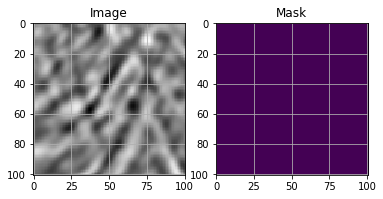

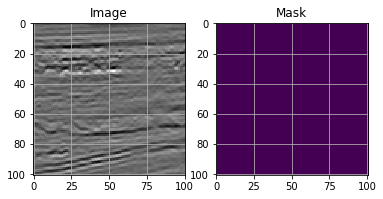

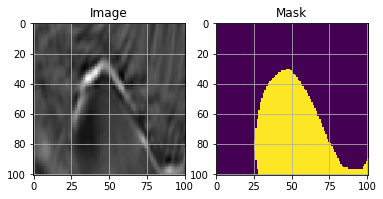

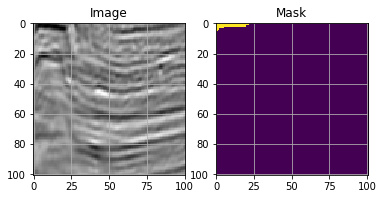

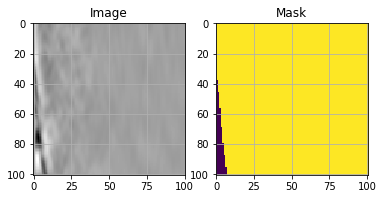

In [0]:
# print the image
for i in range(5):
  image,mask = dataset[np.random.randint(0, len(dataset))]
  plot2x2array(image,mask)

Text(0.5, 1.0, 'depth distribution')

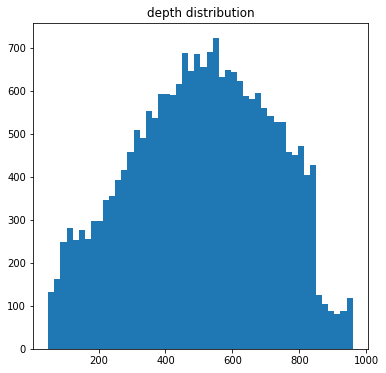

In [0]:
#plot the distribution of depths
plt.figure(figsize = (6,6))
plt.hist(depth['z'], bins = 50)
plt.title('depth distribution')

In [0]:


#convert to image
def rleToMask(rleString,height,width):
    #width heigh
    rows,cols = height,width
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img



In [0]:
#for measuring how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [0]:
#prepare to merge depth
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [26]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5, 1.0, 'Proportion of salt v. depth')

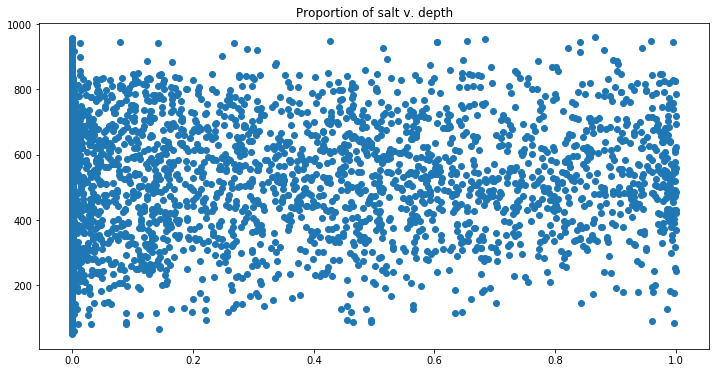

In [27]:


plt.figure(figsize = (12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt v. depth')



In [28]:
print("Correlation: ", np.corrcoef(merged['salt_proportion'], merged['z'])[0, 1])

Correlation:  0.10361580365557428


In [29]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [0]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
#path_train = '../input/train/'
#path_test = '../input/test/'

In [31]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#check out this skip connection thooooo
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

W0618 13:03:26.592440 139916962314112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 13:03:26.666531 139916962314112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 13:03:26.668455 139916962314112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 13:03:26.732782 139916962314112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0618 13:03:27.103085 139916962314112 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [32]:
!pip install ipywidgets

In [33]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 4000/4000 [00:19<00:00, 201.54it/s]


Done!


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [35]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

W0618 13:05:16.454557 139916962314112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - 154s 45ms/step - loss: 0.5714 - val_loss: 0.5170

Epoch 00001: val_loss improved from inf to 0.51704, saving model to model-tgs-salt-1.h5
Epoch 2/50
3400/3400 [==============================] - 153s 45ms/step - loss: 0.5022 - val_loss: 0.4366

Epoch 00002: val_loss improved from 0.51704 to 0.43659, saving model to model-tgs-salt-1.h5
Epoch 3/50
3400/3400 [==============================] - 153s 45ms/step - loss: 0.3889 - val_loss: 0.3645

Epoch 00003: val_loss improved from 0.43659 to 0.36449, saving model to model-tgs-salt-1.h5
Epoch 4/50
3400/3400 [==============================] - 154s 45ms/step - loss: 0.3157 - val_loss: 0.2956

Epoch 00004: val_loss improved from 0.36449 to 0.29561, saving model to model-tgs-salt-1.h5
Epoch 5/50
3400/3400 [==============================] - 152s 45ms/step - loss: 0.2742 - val_loss: 0.2637

Epoch 00005: val_loss improved from 0.29561 to 0.26366, sav